In [65]:
import numpy as np, matplotlib.pyplot as plt, time, copy, random, math
#%load_ext line_profiler
directory = '../data/'
file_paths = ['a_example.txt', 'b_read_on.txt', 'c_incunabula.txt','d_tough_choices.txt', 'e_so_many_books.txt', 'f_libraries_of_the_world.txt']

### Classes

In [38]:
class Library():
    def __init__(self,index,N,T,M):
        self.id = index
        self.size  = N
        self.signup_time = T
        self.books_per_day = M
        self.book_ids = set()
        
    def add_book(self,book):
        self.book_ids.add(book)
        
    def remove_book(self,book):
        self.book_ids.remove(book)
        
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

### Utils

In [39]:
def process_file(filePath):
    with open(directory+filePath,'r') as file:
        content = file.read().split('\n')[:-1];
        B,L,D = content[0].split()
        B,L,D = int(B),int(L),int(D)
    book_libraries = [set() for i in range(B)]
    bookValues = [int(n) for n in content[1].split()]
    libraries = []
    for i in range(L):
        N,T,M = content[2+2*i].split()
        N,T,M=int(N),int(T),int(M)
        book_ids = set(int(id) for id in content[2+2*i+1].split())
        library = Library(i,N,T,M)
        for book_id in book_ids:
            book_libraries[book_id].add(i)
            library.add_book(book_id)
        libraries.append(library)
    return ((B,L,D), bookValues,book_libraries, libraries)

In [40]:
def check_solution(D, libraries):
    days = 0
    prev_books = set()
    lib_ids = [lib.id for lib in libraries]
    assert(len(lib_ids) == len(set(lib_ids)))
    for library in libraries:
        days+=library.signup_time
        if len(library.book_ids) > (D-days)*library.books_per_day:
            print("what", len(library.book_ids), (D-days)*library.books_per_day)
        assert(len(library.book_ids) == len(set(library.book_ids)))
        assert(not any([(book in prev_books) for book in library.book_ids]))
        prev_books.update(library.book_ids)
    assert(days < D)
    
def score_solution(libraries, book_values):
    score=0
    for library in libraries:
        for book_id in library.book_ids:
            score+= book_values[book_id]
    return score

In [41]:
class ProblemSolver:
    def __init__(self, B, L, D, book_values, book_libraries, libraries):
        self.B, self.L, self.D = B,L,D
        self.book_values = book_values
        self.libraries = libraries
        self.book_libraries = copy.copy(book_libraries)
        
    def book_score(self, book):
        return self.book_values[book]
    
    def get_n_best_books(self,lib, n):
        return sorted(lib.book_ids,key=self.book_score, reverse=True)[:n]
        
    def get_solution(self,selected_lib_ids=None):
        if not selected_lib_ids:
            selected_lib_ids = self.get_individual()
        local_book_values = copy.copy(self.book_values)
        day = 0
        selected_libraries = [copy.deepcopy(self.libraries[i]) for i in selected_lib_ids]
        it=0;
        already_scanned_books = set()
        while it < len(selected_libraries):
            next_library = selected_libraries[it]
            day+=next_library.signup_time
            if day>=self.D:
                break
            next_library.book_ids = next_library.book_ids - already_scanned_books
            next_library.book_ids = sorted(next_library.book_ids,key=self.book_score, reverse=True)[:(self.D-day)*next_library.books_per_day]
            already_scanned_books.update(next_library.book_ids)
            it+=1
        return selected_libraries[:it]
    
    def get_individual(self):
        pass

In [42]:
class HeurysticSolver(ProblemSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores/lib.signup_time
    
    def get_individual(self):
        lib_ids = [i for i in range(len(self.libraries))]
        lib_ids.sort(key = self.library_score, reverse= True)
        day = 0
        chosen = []
        for i in range(len(lib_ids)):
            if day + self.libraries[lib_ids[i]].signup_time >= self.D:
                continue  
            day+=self.libraries[lib_ids[i]].signup_time
            chosen.append(lib_ids[i])
        return tuple(chosen)

In [43]:
class PowerSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores/lib.signup_time**(1+lib.signup_time/self.D)

In [44]:
class SimpleScoreVarianceSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        best_scores = [self.book_values[book] for book in n_best_books]
        sum_of_best_book_scores = sum(best_scores)
        book_variance = max(0.001,np.var(best_scores))
        return sum_of_best_book_scores/book_variance

In [45]:
class SquareScoreVarianceSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        best_scores = [self.book_values[book] for book in n_best_books]
        sum_of_best_book_scores = sum(best_scores)
        book_variance = max(0.001,np.var(best_scores))
        return sum_of_best_book_scores**2/(lib.signup_time*lib.signup_time*math.sqrt(book_variance))

In [46]:
class BookNumbersSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        best_scores = [self.book_values[book] for book in n_best_books]
        sum_of_best_book_scores = sum(best_scores)
        book_variance = max(0.001,np.var(best_scores))
        return sum_of_best_book_scores**2/(book_variance*len(n_best_books)*lib.signup_time)

In [47]:
class ScoreSquareSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores**2/lib.signup_time

In [48]:
class BookCountSolver(HeurysticSolver):
    def book_score(self, book):
        return self.book_values[book] - 0.7*len(self.book_libraries[book])

In [49]:
class BookCountPowerSolver(PowerSolver):
    def book_score(self, book):
        return self.book_values[book] - 0.7*len(self.book_libraries[book])

In [50]:
sum_score = 0
solvers_cls = [HeurysticSolver, PowerSolver, SimpleScoreVarianceSolver, SquareScoreVarianceSolver, BookNumbersSolver, ScoreSquareSolver, BookCountSolver, BookCountPowerSolver]
for file_path in file_paths:
    (B,L,D),book_values,book_counts, libraries = process_file(file_path)
    solvers = [cl(B,L,D,book_values,book_counts, libraries) for cl in solvers_cls]
    %time solutions = [solver.get_solution() for solver in solvers]
#     print(list(lib.id for lib in solutions[0]))
    [check_solution(D, solution) for solution in solutions]
    scores = [score_solution(solution, book_values) for solution in solutions]
    print(scores)
    score = max(scores)
    print(score)
    sum_score+=score
print("SUM",sum_score)

CPU times: user 1.15 ms, sys: 60 µs, total: 1.21 ms
Wall time: 1.1 ms
[21, 21, 21, 21, 21, 21, 21, 21]
21
CPU times: user 310 ms, sys: 0 ns, total: 310 ms
Wall time: 310 ms
[5822900, 5822900, 5822900, 5822900, 5822900, 5822900, 5822900, 5822900]
5822900
CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
Wall time: 1.43 s
[5645747, 5644690, 1191778, 5632921, 5309433, 5530843, 5645747, 5644690]
5645747
CPU times: user 4.08 s, sys: 31.7 ms, total: 4.11 s
Wall time: 4.08 s
[4815395, 4815395, 4815395, 4815395, 4815395, 4815395, 4815395, 4815395]
4815395
CPU times: user 1.57 s, sys: 4.17 ms, total: 1.57 s
Wall time: 1.56 s
[5020495, 5023616, 774717, 4791445, 2797585, 4741433, 5021339, 5024351]
5024351
CPU times: user 1.77 s, sys: 11.3 ms, total: 1.78 s
Wall time: 1.84 s
[5240161, 5238624, 1326571, 5211764, 4111186, 5083231, 5240157, 5238622]
5240161
SUM 26548575


In [51]:
class RandomSolver(ProblemSolver):
    def get_individual(self):
        lib_ids = [i for i in range(len(self.libraries))]
        random.shuffle(lib_ids)
        day = 0
        for i in range(len(lib_ids)):
            day += self.libraries[lib_ids[i]].signup_time
            if day >= self.D:
                return tuple(lib_ids[:i])
        return tuple(lib_ids)

In [52]:
class GreedyIntervalSolver:
    def __init__(self, B, L, D, book_values, book_libraries, libraries):
        self.B, self.L, self.D = B, L, D
        self.book_values = book_values
        self.libraries = libraries
        self.book_libraries = copy.copy(book_libraries)

    def book_score(self, book_id):
        return self.book_values[book_id] - 0.7 * len(self.book_libraries[book_id])

    def get_n_best_books(self, lib, n):
        return sorted(lib.book_ids, key=self.book_score, reverse=True)[:n]

    def library_score(self, lib_id, current_day):
        lib = self.libraries[lib_id]
        delta_time = self.D - current_day - lib.signup_time
        n_best_books = self.get_n_best_books(lib, min(delta_time * lib.books_per_day, len(lib.book_ids)))
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        sum_of_best_book_scores /= lib.signup_time
        return sum_of_best_book_scores  # / lib.signup_time ** (1 + lib.signup_time / self.D)

    def get_solution(self):
        libraries = [copy.deepcopy(library) for library in self.libraries]
        remaining_libraries = set(lib.id for lib in libraries)
        day = 0
        chosen_libraries = []
        it = 0
        while len(remaining_libraries) > 0:
            if it % 25 == 0:
                library_scores = [(self.library_score(lib_id, day), lib_id) for lib_id in remaining_libraries]
            it += 1
            max_el = max(library_scores, key=lambda x: x[0])
            library_scores.remove(max_el)
            score, lib_id = max_el
            remaining_libraries.remove(lib_id)
            library = libraries[lib_id]
            if day + library.signup_time >= self.D:
                break
            day += library.signup_time
            books_to_take = (self.D - day) * library.books_per_day
            sorted_books = sorted(library.book_ids, key=self.book_score, reverse=True)
            for book_id in sorted_books[:books_to_take]:
                for lib_id in self.book_libraries[book_id]:
                    if lib_id != library.id:
                        libraries[lib_id].remove_book(book_id)

            for book_id in sorted_books[books_to_take:]:
                self.book_libraries[book_id].remove(library.id)

            library.book_ids = sorted_books[:books_to_take]
            chosen_libraries.append(library)
        return chosen_libraries

    def get_individual_from_solution(self, solution):
        return tuple([lib.id for lib in solution])

In [82]:
class GeneticSolver(ProblemSolver):
    def __init__(self, B, L, D, book_values,book_libraries, libraries, pop_size = 20, p_mutate = 0.5, surv_rate = 0.2, tournament_size = 3):
        super().__init__(B, L, D, book_values,book_libraries, libraries)
        num = 1
        mult = len(libraries)
        while num < pop_size and mult != 1:
            num*=mult
            mult-=1
        self.pop_size = min(pop_size,num)
        self.p_mutate = p_mutate
        self.tournament_size = min(self.pop_size,tournament_size)
        self.surv_rate = surv_rate
        
        self.indiv_scores = dict()
        self.lib_ids = [i for i in range(len(libraries))]
        self.lib_scores = [self.lib_score(lib) for lib in self.libraries]
        
    def lib_score(self, lib):
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores / lib.signup_time
        
        
    def mutate(self, individual):
        new_one = list(individual)
        if random.random() <=0.5:
            #internal mutation
            length = len(new_one)
            for i in range(4):
                a,b = random.sample(range(length), 2)
                new_one[a],new_one[b] =new_one[b],new_one[a]
            return tuple(individual)                  
        else:
            #exxternal mutation
            additional = random.choices(self.lib_ids, k=4, weights = self.lib_scores)
            unique = set(additional)
            for un in unique:
                new_one.insert(random.randrange(0,len(new_one)), un)
            return self.cut(new_one)
            
    def cut(self, new_one):
        day =0;
        chosen = set()
        solution = []
        for i in range(len(new_one)):
            if new_one[i] not in chosen:
                day+=self.libraries[new_one[i]].signup_time
                if day >= self.D:
                    continue
                solution.append(new_one[i])
                chosen.add(new_one[i])
        return tuple(solution)
    
    def crossover(self,indiv_1, indiv_2):
        set1 = set(indiv_1)
        set2 = set(indiv_2)
        common = set1.intersection(set2)
        maxLen = max(len(indiv_1), len(indiv_2))
        child1,child2,=[-1]*maxLen,[-1]*maxLen
        only1,only2 = [],[]
        for i in range(len(indiv_1)):
            if indiv_1[i] in common:
                child1[i] =  indiv_1[i]
            else:
                only1.append(indiv_1[i])
        for i in range(len(indiv_2)):
            if indiv_2[i] in common:
                child2[i] = indiv_2[i]
            else:
                only2.append(indiv_2[i])
        for i in range(maxLen):
            if child1[i] == -1 and len(only2) > 0:
                child1[i] = only2.pop(0)
            if child2[i] == -1 and len(only1) > 0:
                child2[i] = only1.pop(0)
        child1 = [i for i in child1 if i !=-1]
        child2 = [i for i in child2 if i !=-1]
                        
        child1 = self.cut(child1)
        child2 = self.cut(child2)
        if random.random()<=self.p_mutate:
            child1 = self.mutate(child1)
        if random.random()<=self.p_mutate:
            child2 = self.mutate(child2)
        return child1, child2
    
    def tournament(self, indivs):
        return max(indivs, key = self.indiv_scores.get);
    
    def select_survivals(self, population):
        k = int(5*self.pop_size*self.surv_rate)
        weights = [self.indiv_scores[indiv] for indiv in population]
        chosen = []
        already_chosen = set()
        desired = int(self.pop_size*self.surv_rate)
        while len(already_chosen) < desired:
            candidates = random.choices(population, k = k, weights = weights)
            for cand in candidates:
                if cand not in already_chosen:
                    chosen.append(cand)
                    already_chosen.add(cand)
        return chosen
    
    def get_initial_population(self):
        solvers_cls = [HeurysticSolver, PowerSolver, SimpleScoreVarianceSolver, SquareScoreVarianceSolver, BookNumbersSolver, ScoreSquareSolver, BookCountSolver, BookCountPowerSolver]
        solvers = [cl(self.B,self.L,self.D,self.book_values,self.book_libraries, self.libraries) for cl in solvers_cls]
        population = [solver.get_individual() for solver in solvers]
        greedyIntervalSolver = GreedyIntervalSolver(self.B,self.L,self.D,self.book_values,self.book_libraries, self.libraries)
        greedyIntervalSolution = greedyIntervalSolver.get_solution();
        gis_individual = greedyIntervalSolver.get_individual_from_solution(greedyIntervalSolution)
        population.append(gis_individual)
        self.indiv_scores[gis_individual] = score_solution(greedyIntervalSolution, self.book_values)
        randomSolver = RandomSolver(self.B,self.L,self.D,self.book_values,self.book_libraries, self.libraries)
        while len(population) < self.pop_size:
            population.append(randomSolver.get_individual())
        return population
    
    def get_individual(self):
        population = self.get_initial_population()
        for indiv in population:
            sol = self.get_solution(indiv)
            self.indiv_scores[indiv] = score_solution(sol, self.book_values)
        startTime = time.time()
        progress = []
        cur_state = []
        times = []
        while(True):
            progress.append(max(self.indiv_scores.values()))
            cur_state.append(max([self.indiv_scores[pop] for pop in population]))
            times.append(time.time() - startTime)
            if(time.time() - startTime > 290):
                break
            new_population = [ self.tournament(random.sample(population, self.tournament_size)) for i in range(int(self.pop_size*self.surv_rate))]
            new_population.append(max([(self.indiv_scores[indiv], indiv) for indiv in population])[1])
            while len(new_population) < self.pop_size:
                indiv_1 = self.tournament(random.sample(population, self.tournament_size))
                indiv_2 = self.tournament(random.sample(population, self.tournament_size))
                if random.random()<= 0.5:
                    new_child1 = self.mutate(indiv_1)
                    new_child2 = self.mutate(indiv_2)
                else:
                    new_child1, new_child2 = self.crossover(indiv_1, indiv_2)
                if new_child1 not in self.indiv_scores:
                    self.indiv_scores[new_child1] = score_solution(self.get_solution(new_child1), book_values)
                if new_child2 not in self.indiv_scores:
                    self.indiv_scores[new_child2] = score_solution(self.get_solution(new_child2), book_values)
                new_population.append(new_child1)
                new_population.append(new_child2)
            population = tuple(new_population)
        plt.title("Progress min,max"+str(min(progress))+", "+str(max(progress)))
        plt.scatter(times,progress, color="blue", label = "progress", alpha=0.5)
        plt.scatter(times,cur_state, color="red", label = "cur_state", alpha=0.5)
        plt.show()
        return max(self.indiv_scores, key = self.indiv_scores.get)
              

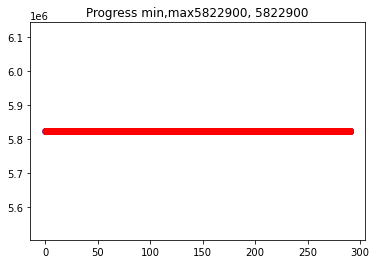

S:  5822900


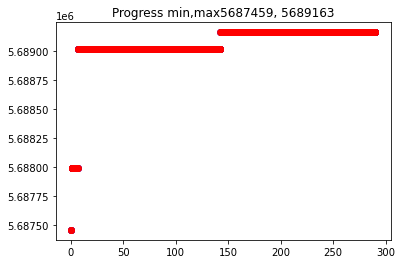

S:  5689163


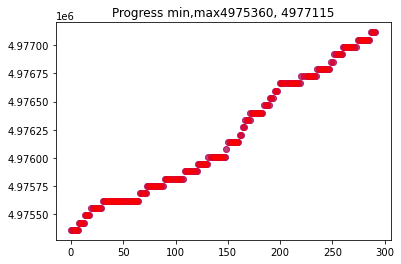

S:  4977115


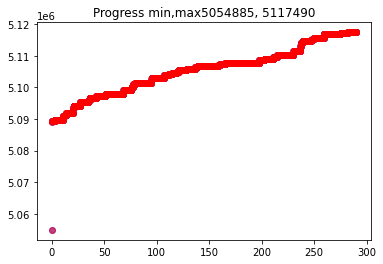

S:  5117490


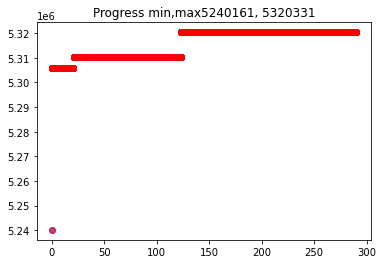

S:  5320331
26926999


In [83]:
sum_score =0
for file_path in file_paths[1:]:
    (B, L, D), book_values,book_counts, libraries = process_file(file_path)
    solver = GeneticSolver(B, L, D, book_values, book_counts, libraries, 20)
    solution = solver.get_solution()
    check_solution(D, solution)
    score = score_solution(solution, book_values)
    print("S: ",score)
    sum_score += score

print(sum_score)

In [41]:
sum_score =0
for file_path in file_paths:
    (B, L, D), book_values,book_counts, libraries = process_file(file_path)
    print(sum(book_values))

21
10000000
30076415
5109000
12548648
40111142
